In [4]:

import pandas as pd
from sqlalchemy import create_engine
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import plotly.graph_objects as go

In [1]:
%pip install PyMySQL

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
%pip install plotly

   ---------------------------------------- 0.0/9.9 MB ? eta -:--:--
   ------ --------------------------------- 1.6/9.9 MB 10.0 MB/s eta 0:00:01
   --------------- ------------------------ 3.9/9.9 MB 10.1 MB/s eta 0:00:01
   ---------------------- ----------------- 5.5/9.9 MB 9.5 MB/s eta 0:00:01
   ---------------------------- ----------- 7.1/9.9 MB 9.1 MB/s eta 0:00:01
   ------------------------------------ --- 8.9/9.9 MB 8.8 MB/s eta 0:00:01
   ---------------------------------------  9.7/9.9 MB 8.2 MB/s eta 0:00:01
   ---------------------------------------- 9.9/9.9 MB 8.0 MB/s  0:00:01
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:

DB_USER = 'root'
DB_PASS = '123456789'
DB_HOST = 'localhost'
DB_NAME = 'cricket_analysis_db' 

# Create the SQLAlchemy engine for connection
try:
    engine = create_engine(f"mysql+pymysql://{DB_USER}:{DB_PASS}@{DB_HOST}/{DB_NAME}")

    # Load tables into separate DataFrames
    df_odi = pd.read_sql('SELECT * FROM odi_matches', engine)
    df_t20 = pd.read_sql('SELECT * FROM t20_matches', engine)
    df_test = pd.read_sql('SELECT * FROM test_matches', engine)
    
    print(" DataFrames loaded successfully!")
    print(f"ODI Matches: {len(df_odi)} rows")
    print(f"T20 Matches: {len(df_t20)} rows")
    print(f"Test Matches: {len(df_test)} rows")
    
    # Create a combined DataFrame for cross-format analysis
    df_all = pd.concat([df_odi, df_t20, df_test], ignore_index=True)
    print(f"Combined DataFrame (All Formats): {len(df_all)} rows")
    
except Exception as e:
    print(f" ERROR connecting or reading data from MySQL.")
    print(f"Please ensure the MySQL service is running and credentials are correct.")
    print(f"Details: {e}")

✅ DataFrames loaded successfully!
ODI Matches: 3072 rows
T20 Matches: 4775 rows
Test Matches: 885 rows
Combined DataFrame (All Formats): 8732 rows


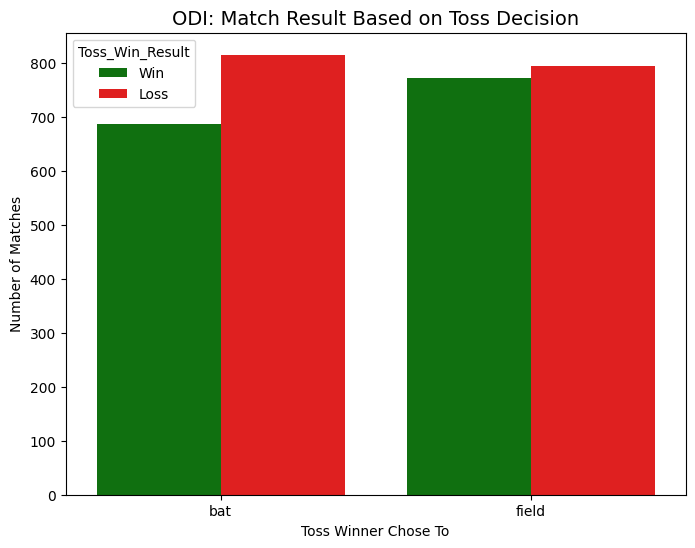

In [ ]:
#1.Match Result Distribution by Toss Decision (ODI)
#Type: Stacked Bar Chart (Seaborn)
# Insight: What percentage of matches are won after the toss winner chooses to bat vs. field?
# Calculate TOSS WIN vs. MATCH WIN
df_odi['Toss_Win_Result'] = df_odi.apply(
    lambda x: 'Win' if x['Toss_Winner'] == x['Match_Winner'] else 'Loss', axis=1
)

plt.figure(figsize=(8, 6))
sns.countplot(
    data=df_odi,
    x='Choose_To',
    hue='Toss_Win_Result',
    palette={'Win': 'green', 'Loss': 'red'},
    order=['bat', 'field']
)
plt.title('ODI: Match Result Based on Toss Decision', fontsize=14)
plt.xlabel('Toss Winner Chose To')
plt.ylabel('Number of Matches')
plt.show()

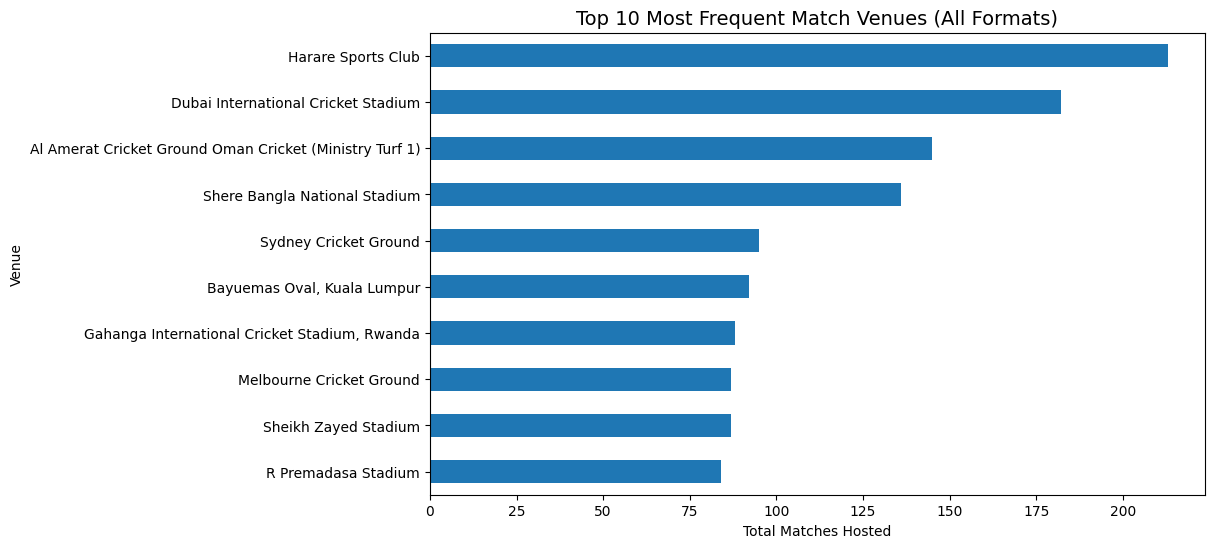

In [ ]:
#2.Top 10 Venues by Match Count
#Type: Horizontal Bar Chart 
#Insight: Which stadiums are used most frequently
plt.figure(figsize=(10, 6))
df_all['Venue'].value_counts().nlargest(10).sort_values(ascending=True).plot(kind='barh')
plt.title('Top 10 Most Frequent Match Venues (All Formats)', fontsize=14)
plt.xlabel('Total Matches Hosted')
plt.ylabel('Venue')
plt.show()

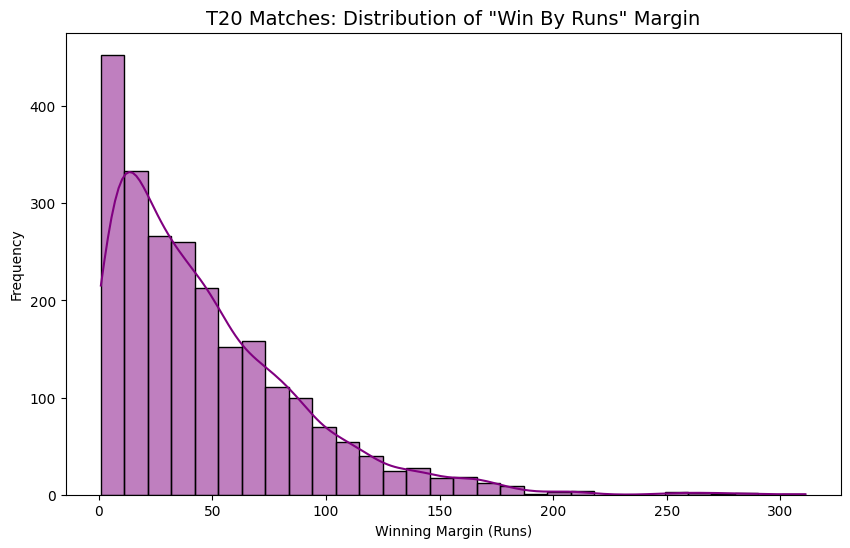

In [ ]:
#3. Histogram of Victory Margins by Runs (T20)
#What is the most common winning margin when a team bats first?
plt.figure(figsize=(10, 6))
sns.histplot(df_t20[df_t20['Win_By_Runs'] > 0]['Win_By_Runs'], bins=30, kde=True, color='purple')
plt.title('T20 Matches: Distribution of "Win By Runs" Margin', fontsize=14)
plt.xlabel('Winning Margin (Runs)')
plt.ylabel('Frequency')
plt.show()

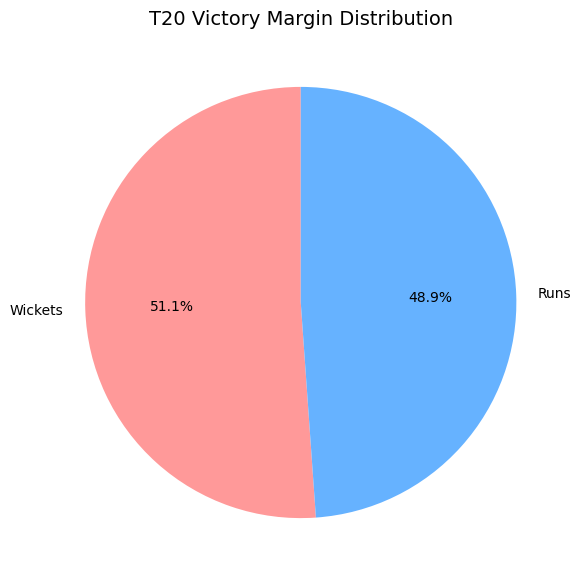

In [ ]:
#4. Distribution of Victory Margin Types (T20)
# How often are T20s decided by runs (batting first) versus wickets (chasing)?

decisive_wins = df_t20[df_t20['Match_Winner'] != 'No Result'].copy()
decisive_wins['Margin_Type'] = decisive_wins.apply(
    lambda x: 'Runs' if x['Win_By_Runs'] > 0 else 'Wickets', axis=1
)

margin_counts = decisive_wins['Margin_Type'].value_counts()
plt.figure(figsize=(7, 7))
plt.pie(
    margin_counts,
    labels=margin_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=['#FF9999', '#66B2FF']
)
plt.title('T20 Victory Margin Distribution', fontsize=14)
plt.show()

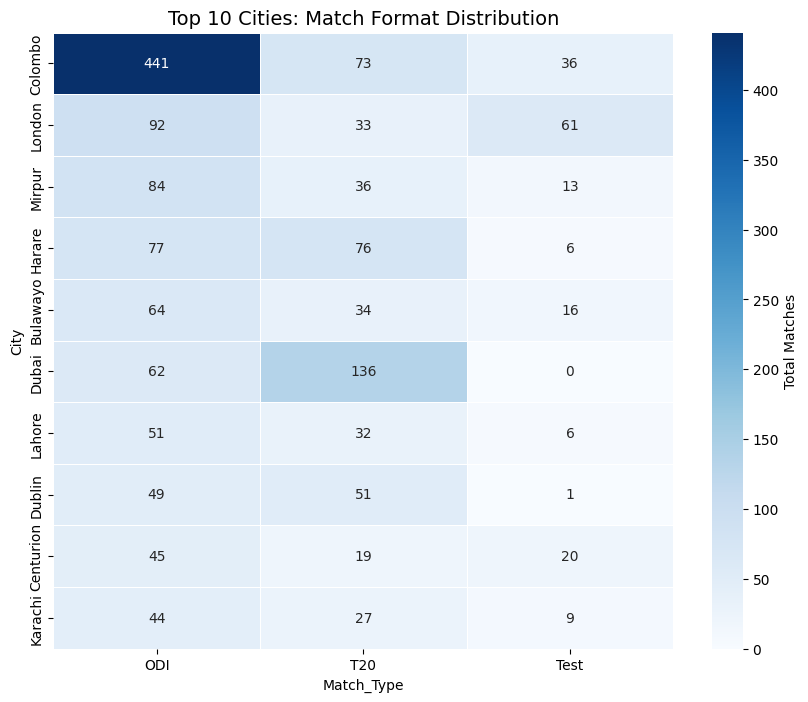

In [ ]:
#5.City-wise Distribution of Match Types
# Which cities host a diverse range of formats?
city_format_pivot = df_all.groupby(['City', 'Match_Type']).size().unstack(fill_value=0)
city_format_pivot = city_format_pivot.nlargest(10, 'ODI') # Filter top 10 ODI cities

plt.figure(figsize=(10, 8))
sns.heatmap(
    city_format_pivot,
    annot=True,
    fmt='d',
    cmap='Blues',
    linewidths=.5,
    cbar_kws={'label': 'Total Matches'}
)
plt.title('Top 10 Cities: Match Format Distribution', fontsize=14)
plt.show()

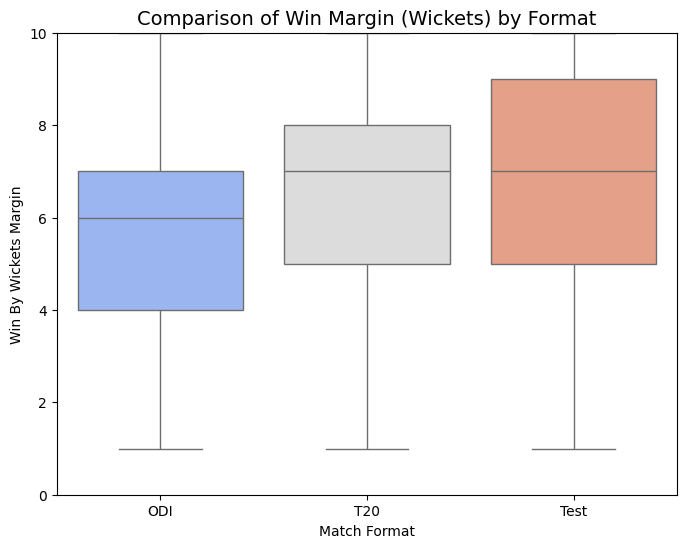

In [ ]:
#6.Box Plot of Victory Margins (Wickets) Across Match Types
# Are chasing wins tighter or more dominant in ODIs vs. T20s
# The original code block
df_wins_by_wickets = df_all[df_all['Win_By_Wickets'] > 0] 

plt.figure(figsize=(8, 6))

# FIX: Explicitly assign hue=x variable and set legend=False
sns.boxplot(
    x='Match_Type', 
    y='Win_By_Wickets', 
    data=df_wins_by_wickets, 
    hue='Match_Type',     # <--- ADD THIS LINE
    palette='coolwarm',
    legend=False          # <--- ADD THIS LINE
)

plt.title('Comparison of Win Margin (Wickets) by Format', fontsize=14)
plt.xlabel('Match Format')
plt.ylabel('Win By Wickets Margin')
plt.ylim(0, 10)
plt.show()

C:\Users\Aakankhya\AppData\Local\Temp\ipykernel_6352\2947353364.py:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




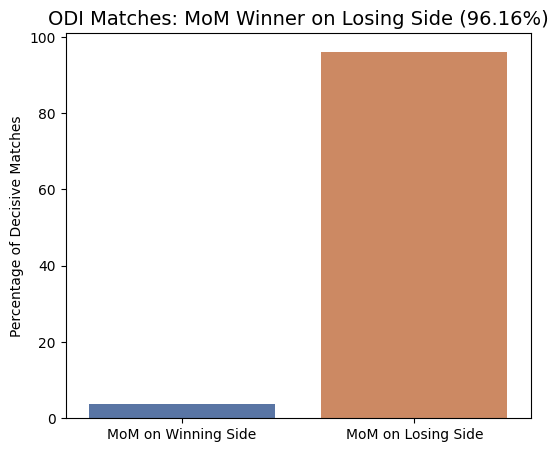

In [ ]:
#7.Identify matches where MoM winner was NOT on the winning team
df_odi['MoM_Loss'] = df_odi.apply(
    lambda row: 1 if row['Man_Of_Match'] != row['Match_Winner'] and row['Match_Winner'] != 'No Result' else 0, 
    axis=1
)

upset_rate = df_odi['MoM_Loss'].sum() / df_odi[df_odi['Match_Winner'] != 'No Result'].shape[0] * 100

plt.figure(figsize=(6, 5))
sns.barplot(x=['MoM on Winning Side', 'MoM on Losing Side'], 
            y=[100 - upset_rate, upset_rate], 
            palette=['#4c72b0', '#dd8452'])
plt.title(f'ODI Matches: MoM Winner on Losing Side ({upset_rate:.2f}%)', fontsize=14)
plt.ylabel('Percentage of Decisive Matches')
plt.show()

C:\Users\Aakankhya\AppData\Local\Temp\ipykernel_6352\3260020253.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




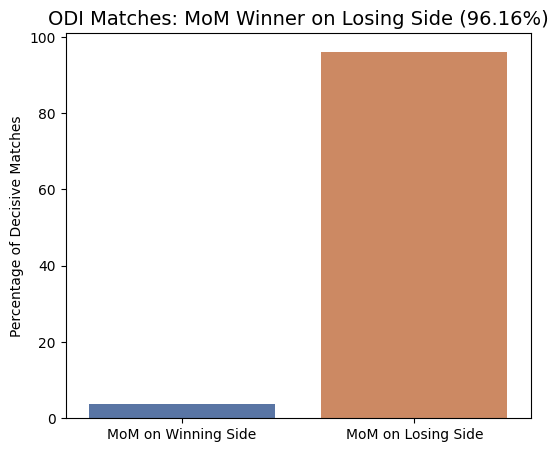

In [ ]:
#8.upset Rate: MoM Winner on the Losing Side (ODI)
# Measures the rate of "upsets" or matches where a single player had an exceptional performance but was on the losing side.

df_odi['MoM_Loss'] = df_odi.apply(
    lambda row: 1 if row['Man_Of_Match'] != row['Match_Winner'] and row['Match_Winner'] != 'No Result' else 0, 
    axis=1
)

upset_rate = df_odi['MoM_Loss'].sum() / df_odi[df_odi['Match_Winner'] != 'No Result'].shape[0] * 100

plt.figure(figsize=(6, 5))
sns.barplot(x=['MoM on Winning Side', 'MoM on Losing Side'], 
            y=[100 - upset_rate, upset_rate], 
            palette=['#4c72b0', '#dd8452'])
plt.title(f'ODI Matches: MoM Winner on Losing Side ({upset_rate:.2f}%)', fontsize=14)
plt.ylabel('Percentage of Decisive Matches')
plt.show()

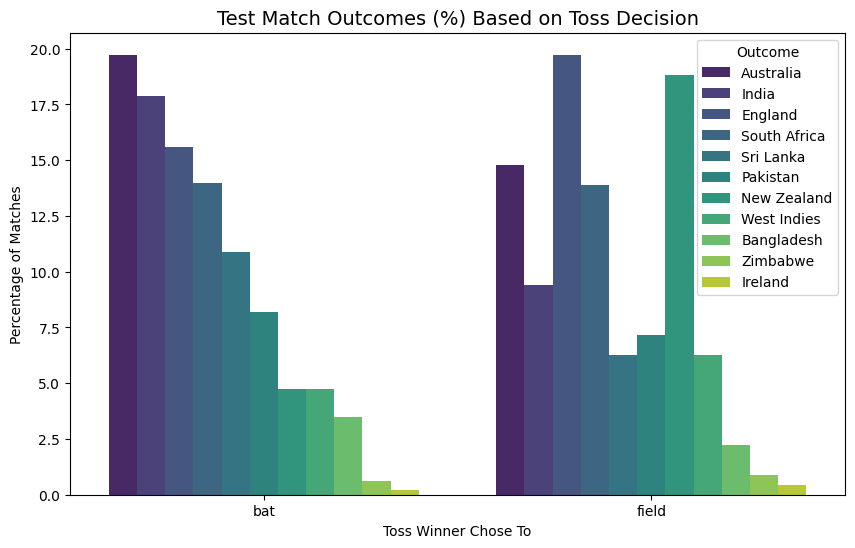

In [21]:
#9. Toss Advantage in Test Cricket (Draw Rate)
#Does the toss decision significantly influence the frequency of a Draw in Test matches?
# Calculate the outcome percentage based on the Choose_To decision
test_outcomes = df_test.groupby('Choose_To')['Match_Winner'].value_counts(normalize=True).mul(100).rename('Percentage').reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(
    data=test_outcomes,
    x='Choose_To',
    y='Percentage',
    hue='Match_Winner',
    palette='viridis'
)
plt.title('Test Match Outcomes (%) Based on Toss Decision', fontsize=14)
plt.xlabel('Toss Winner Chose To')
plt.ylabel('Percentage of Matches')
plt.xticks(rotation=0)
plt.legend(title='Outcome')
plt.show()

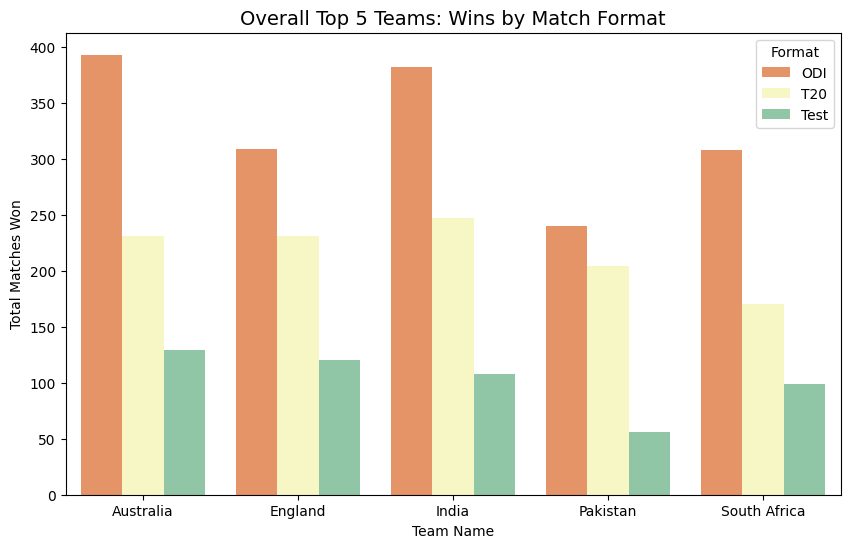

In [ ]:
#10. Top 5 Teams by Overall Win Count (Combined Formats)
# A definitive ranking of the most successful teams across all match types in the dataset.

df_winners = df_all[df_all['Match_Winner'].notna() & (df_all['Match_Winner'] != 'No Result')].copy()


top_5_winners = df_winners['Match_Winner'].value_counts().nlargest(5).index
df_top_5 = df_winners[df_winners['Match_Winner'].isin(top_5_winners)]


win_counts = df_top_5.groupby(['Match_Winner', 'Match_Type']).size().reset_index(name='Wins')

plt.figure(figsize=(10, 6))
sns.barplot(
    data=win_counts,
    x='Match_Winner',
    y='Wins',
    hue='Match_Type',
    palette='Spectral'
)
plt.title('Overall Top 5 Teams: Wins by Match Format', fontsize=14)
plt.xlabel('Team Name')
plt.ylabel('Total Matches Won')
plt.legend(title='Format')
plt.show()